# DANN Training and Evaluation

This notebook contains the code for training and evaluating a Domain-Adversarial Neural Network (DANN) for domain adaptation tasks. The main sections of this notebook include:
1. **Model Definition and Hyperparameters**
2. **Data Loading and Preparation**
3. **Model Training**
4. **Results and Visualization**

You can find the complete code and results on [GitHub](https://github.com/hatem2040/OCT-DANN-).

---

## 1. Model Definition and Hyperparameters

In this section, we define the DANN model and specify the hyperparameters for training.


In [1]:
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import datetime
from concurrent.futures import ThreadPoolExecutor
import json
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np  # Import numpy for array operations

# Updated Hyperparameters
BATCH_SIZE = 32
EPOCHS = 20
PATIENCE = 10 
ALPHA = 0.25  # used to be 0.5
LEARNING_RATE = 0.0001 
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 5
LABEL_PREDICTOR_ACTIVATION = 'relu'
DOMAIN_CLASSIFIER_ACTIVATION = 'sigmoid'
FINAL_ACTIVATION = 'softmax'

# Directories for saving the model and logs
model_dir = "0model_dir5AugV3"
logs_path = "0logs_path5AugV3"

# Getting the current date and time to append to the filenames
current_datetime = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
model_file = os.path.join(model_dir, f'dann_model_{current_datetime}.weights.h5')
logs_file = os.path.join(logs_path, f'logs_{current_datetime}.json')
experiment_details_file = os.path.join(logs_path, f'experiment_details_{current_datetime}.json')

# Ensure directories exist
os.makedirs(model_dir, exist_ok=True)
os.makedirs(logs_path, exist_ok=True)

# Record the start time of the experiment
start_time = datetime.datetime.now()

# Record the experiment details
experiment_details = {
    'experiment_name': 'My Experiment',
    'dataset': 'Source Test Dataset',
    'model': 'DANN',
    'hyperparameters': {
        'batch_size': BATCH_SIZE,
        'epochs': EPOCHS,
        'patience': PATIENCE,
        'alpha': ALPHA,
        'learning_rate': LEARNING_RATE,
        'label_predictor_activation': LABEL_PREDICTOR_ACTIVATION,
        'domain_classifier_activation': DOMAIN_CLASSIFIER_ACTIVATION,
        'final_activation': FINAL_ACTIVATION
    }
}

print(f"Experiment started at {start_time}")
print("Experiment details:")
print(experiment_details)

# Save experiment details
with open(experiment_details_file, 'w') as f:
    json.dump(experiment_details, f)

# Define the DANN Model
class GRL1(tf.keras.layers.Layer):
    def __init__(self, alpha):
        super(GRL1, self).__init__()
        self.alpha = alpha

    def call(self, x):
        @tf.custom_gradient
        def grad_reverse(x):
            def custom_grad(dy):
                return -self.alpha * dy
            return x, custom_grad
        return grad_reverse(x)

def build_feature_extractor(trainable=True):
    base_model = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
    base_model.trainable = trainable  # Set this to True to unfreeze layers

    #Unfreezing only last layers
    if trainable:
        for layer in base_model.layers[-4:]:  # Unfreeze last 4 layers 
            layer.trainable = True

    model = tf.keras.Sequential([
        base_model
    ])
    return model

def build_label_predictor():
    model = tf.keras.Sequential([
        Conv2D(64, (3, 3), activation=LABEL_PREDICTOR_ACTIVATION, input_shape=(7, 7, 1024), use_bias=True),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation=LABEL_PREDICTOR_ACTIVATION),
        Dense(NUM_CLASSES, activation=FINAL_ACTIVATION)
    ])
    return model

def build_domain_classifier():
    model = tf.keras.Sequential([
        Conv2D(64, (3, 3), activation=DOMAIN_CLASSIFIER_ACTIVATION, input_shape=(7, 7, 1024)),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation=DOMAIN_CLASSIFIER_ACTIVATION),
        Dense(2)  # binary domain classification
    ])
    return model

class DANN(tf.keras.Model):
    def __init__(self):
        super(DANN, self).__init__()
        self.feature_extractor = build_feature_extractor()
        self.label_predictor = build_label_predictor()
        self.domain_classifier = build_domain_classifier()
    
    def call(self, x, alpha=0):
        features = self.feature_extractor(x)
        reverse_features = GRL1(alpha)(features)
        label_predictions = self.label_predictor(features)
        domain_predictions = self.domain_classifier(reverse_features)
        return label_predictions, domain_predictions


Experiment started at 2024-08-21 20:05:18.258698
Experiment details:
{'experiment_name': 'My Experiment', 'dataset': 'Source Test Dataset', 'model': 'DANN', 'hyperparameters': {'batch_size': 32, 'epochs': 20, 'patience': 10, 'alpha': 0.25, 'learning_rate': 0.0001, 'label_predictor_activation': 'relu', 'domain_classifier_activation': 'sigmoid', 'final_activation': 'softmax'}}


## 2. Data Loading and Preparation

In this section, we define the functions to load, process, and augment the data used for training and evaluation.


In [2]:
def resize_images(images, target_height, target_width):
    return tf.image.resize(images, [target_height, target_width])

def ensure_rgb(images):
    if images.shape[-1] == 1:
        return tf.image.grayscale_to_rgb(images)
    elif images.shape[-1] == 3:
        return images
    else:
        raise ValueError(f"Expected images of shape [batch_size, height, width, 1 or 3], but got {images.shape}")

def load_labeled_data_parallel(data_dir):
    def load_images_for_label(label):
        class_dir = os.path.join(data_dir, str(label))
        return [(os.path.join(class_dir, file), label, label - 1) for file in os.listdir(class_dir) if file.endswith('.png')]

    images, labels, label_indices = [], [], []
    with ThreadPoolExecutor() as executor:
        results = executor.map(load_images_for_label, range(1, 6))
        for result in results:
            for img_path, label, label_index in result:
                images.append(img_path)
                labels.append(label)
                label_indices.append(label_index)
    
    print(f"Loaded {len(images)} labeled images from {data_dir}")
    return images, labels, label_indices

def load_unlabeled_data(data_dir):
    images = []
    for file in os.listdir(data_dir):
        if file.endswith('.png'):
            images.append(os.path.join(data_dir, file))
    print(f"Loaded {len(images)} unlabeled images from {data_dir} ")
    return images

def load_data(data_dir, batch_size=BATCH_SIZE, labeled=True):
    if labeled:
        images, labels, label_indices = load_labeled_data_parallel(data_dir)
        dataset = tf.data.Dataset.from_tensor_slices((images, label_indices))
        dataset = dataset.map(lambda img, lbl: (augment_image(read_image(img)), lbl), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    else:
        images = load_unlabeled_data(data_dir)
        dataset = tf.data.Dataset.from_tensor_slices(images)
        dataset = dataset.map(lambda img: augment_image(read_image(img)), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    print(f"Created dataset from {data_dir} with batch size {batch_size}")
    return dataset

def read_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.grayscale_to_rgb(image)  # Convert to RGB
    image = tf.image.resize(image, [224, 224])  # Ensure resizing to 224x224
    image = tf.cast(image, tf.float32) / 255.0
    return image

def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    return image

# Data directories
source_train_data_dir = '/Users/hatem/Library/CloudStorage/OneDrive-QueenMary,UniversityofLondon/MyDANN OneDrive/DANN_Apocrita/PigData_PP/training'
source_test_data_dir = '/Users/hatem/Library/CloudStorage/OneDrive-QueenMary,UniversityofLondon/MyDANN OneDrive/DANN_Apocrita/PigData_PP/test'
source_val_data_dir = '/Users/hatem/Library/CloudStorage/OneDrive-QueenMary,UniversityofLondon/MyDANN OneDrive/DANN_Apocrita/PigData_PP/val'
target_train_data_dir = '/Users/hatem/Library/CloudStorage/OneDrive-QueenMary,UniversityofLondon/MyDANN OneDrive/DANN_Apocrita/HumanData_PP/train'
target_val_data_dir = '/Users/hatem/Library/CloudStorage/OneDrive-QueenMary,UniversityofLondon/MyDANN OneDrive/DANN_Apocrita/HumanData_PP/val'

# Load the datasets
source_train_dataset = load_data(source_train_data_dir, batch_size=BATCH_SIZE, labeled=True)
source_test_dataset = load_data(source_test_data_dir, batch_size=BATCH_SIZE, labeled=True)
source_val_dataset = load_data(source_val_data_dir, batch_size=BATCH_SIZE, labeled=True)
target_train_dataset = load_data(target_train_data_dir, batch_size=BATCH_SIZE, labeled=False)
target_val_dataset = load_data(target_val_data_dir, batch_size=BATCH_SIZE, labeled=False)

Loaded 2590 labeled images from /Users/hatem/Library/CloudStorage/OneDrive-QueenMary,UniversityofLondon/MyDANN OneDrive/DANN_Apocrita/PigData_PP/training
Created dataset from /Users/hatem/Library/CloudStorage/OneDrive-QueenMary,UniversityofLondon/MyDANN OneDrive/DANN_Apocrita/PigData_PP/training with batch size 32
Loaded 370 labeled images from /Users/hatem/Library/CloudStorage/OneDrive-QueenMary,UniversityofLondon/MyDANN OneDrive/DANN_Apocrita/PigData_PP/test
Created dataset from /Users/hatem/Library/CloudStorage/OneDrive-QueenMary,UniversityofLondon/MyDANN OneDrive/DANN_Apocrita/PigData_PP/test with batch size 32
Loaded 740 labeled images from /Users/hatem/Library/CloudStorage/OneDrive-QueenMary,UniversityofLondon/MyDANN OneDrive/DANN_Apocrita/PigData_PP/val
Created dataset from /Users/hatem/Library/CloudStorage/OneDrive-QueenMary,UniversityofLondon/MyDANN OneDrive/DANN_Apocrita/PigData_PP/val with batch size 32
Loaded 2246 unlabeled images from /Users/hatem/Library/CloudStorage/OneD

## 3. Model Training

Here, we train the DANN model using the source and target datasets. The model is saved, and logs are maintained for training and validation metrics.


In [3]:
def evaluate_model(model, dataset, labeled=True, loss_metric=None):
    accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    
    for batch in dataset:
        if labeled:
            images, labels = batch
        else:
            images = batch
            labels = tf.zeros((len(images),), dtype=tf.int32)
        
        images_rgb = ensure_rgb(images)
        images_resized = resize_images(images_rgb, 224, 224)
        preds, _ = model(images_resized, alpha=ALPHA)
        accuracy_metric.update_state(labels, preds)
        
        if loss_metric:
            loss = tf.keras.losses.sparse_categorical_crossentropy(labels, preds)
            loss_metric.update_state(loss)
    
    return accuracy_metric.result().numpy()

def train_classifier_eta(dann, source_train_data, target_train_data, source_val_data, epochs=EPOCHS):
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    label_loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
    domain_loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    best_val_accuracy = 0
    patience_counter = 0
    train_losses = []
    val_losses = []
    patience_counter = 0
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        print(f'Starting epoch {epoch+1}/{epochs}')
        epoch_train_loss = 0
        epoch_val_loss = 0
        num_batches = 0
        train_accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()
        val_accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()

        source_train_iter = iter(source_train_data)
        target_train_iter = iter(target_train_data)
        source_val_iter = iter(source_val_data)

        while True:
            try:
                # Training step
                source_train_batch = next(source_train_iter)
                target_train_batch = next(target_train_iter)
            except StopIteration:
                break
            
            # Process training batch
            source_train_images, source_train_labels = source_train_batch
            target_train_images = target_train_batch

            min_batch_size = min(len(source_train_images), len(target_train_images))

            source_train_images = source_train_images[:min_batch_size]
            source_train_labels = source_train_labels[:min_batch_size]
            target_train_images = target_train_images[:min_batch_size]

            with tf.GradientTape() as tape:
                # Ensure the images are RGB and resized
                source_train_images_rgb = ensure_rgb(source_train_images)
                target_train_images_rgb = ensure_rgb(target_train_images)
                source_train_images_resized = resize_images(source_train_images_rgb, 224, 224)
                target_train_images_resized = resize_images(target_train_images_rgb, 224, 224)

                label_preds_train, domain_preds_source_train = dann(source_train_images_resized, alpha=ALPHA)
                _, domain_preds_target_train = dann(target_train_images_resized, alpha=ALPHA)

                source_labels_loss_train = label_loss_object(source_train_labels, label_preds_train)
                source_domain_labels_train = tf.zeros(min_batch_size, dtype=tf.int32)
                target_domain_labels_train = tf.ones(min_batch_size, dtype=tf.int32)

                source_domain_loss_train = domain_loss_object(source_domain_labels_train, domain_preds_source_train)
                target_domain_loss_train = domain_loss_object(target_domain_labels_train, domain_preds_target_train)

                total_loss_train = source_labels_loss_train + source_domain_loss_train + target_domain_loss_train

            gradients = tape.gradient(total_loss_train, dann.trainable_variables)
            optimizer.apply_gradients(zip(gradients, dann.trainable_variables))

            epoch_train_loss += total_loss_train
            train_accuracy_metric.update_state(source_train_labels, label_preds_train)

            # Validation step
            try:
                source_val_batch = next(source_val_iter)
            except StopIteration:
                break

            source_val_images, source_val_labels = source_val_batch

            min_batch_size_val = len(source_val_images)

            source_val_images_rgb = ensure_rgb(source_val_images)
            source_val_images_resized = resize_images(source_val_images_rgb, 224, 224)

            label_preds_val, domain_preds_source_val = dann(source_val_images_resized, alpha=ALPHA)

            source_labels_loss_val = label_loss_object(source_val_labels, label_preds_val)
            source_domain_labels_val = tf.zeros(min_batch_size_val, dtype=tf.int32)

            source_domain_loss_val = domain_loss_object(source_domain_labels_val, domain_preds_source_val)

            total_loss_val = source_labels_loss_val + source_domain_loss_val

            epoch_val_loss += total_loss_val
            val_accuracy_metric.update_state(source_val_labels, label_preds_val)

            num_batches += 1

        epoch_train_loss /= num_batches
        epoch_val_loss /= num_batches

        train_losses.append(float(epoch_train_loss.numpy()))
        val_losses.append(float(epoch_val_loss.numpy()))
        train_accuracies.append(float(train_accuracy_metric.result().numpy()))
        val_accuracies.append(float(val_accuracy_metric.result().numpy()))

        print(f'Epoch {epoch + 1}, Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')
        print(f'Training Accuracy: {train_accuracy_metric.result().numpy():.4f}, Validation Accuracy: {val_accuracy_metric.result().numpy():.4f}')

        # Save model and logs
        dann.save_weights(model_file)
        logs = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies
        }
        with open(logs_file, 'w') as f:
            json.dump(logs, f)

        if val_accuracy_metric.result().numpy() > best_val_accuracy:
            best_val_accuracy = val_accuracy_metric.result().numpy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print("Early stopping triggered.")
                break

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the classifier η (This Part was disabled because the model weights and logs had beeen saved already)

dann = DANN()
# train_losses, val_losses, train_accuracies, val_accuracies = train_classifier_eta(dann, source_train_dataset, target_train_dataset, source_val_dataset, epochs=EPOCHS)


/Users/hatem/miniconda3/envs/Myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 4. Results and Visualization

After training, we plot training history to monitor and compare the training and validation loss and accuracy in order to evaluate the model's performance.


In [4]:
# Plotting training and validation loss, and training and validation accuracy
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 6))
    # Plotting Losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    # Plotting Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy over Epochs')
    plt.legend()
    plt.tight_layout()
    plt.show()

    


# # Call this function to monitor performancne / the training history data (This part can be used to monitor the model performance while training)
# plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)


# Model Evaluation and Analysis

After selecting the best model, we skip the training process and focus on loading the saved weights and logs to evaluate the model. This section includes:
1. **Loading and Evaluating the Saved Model**
2. **Plotting Training and Validation Metrics**
3. **Model Performance Analysis**
4. **Model Robustness Check**


## 1. Loading and Evaluating the Saved Model

Here, we load the saved model weights and logs to evaluate the model's performance on the validation dataset.


In [5]:
import os
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE

# Paths to the logs and model directories
logs_dir = "0logs_path5AugV3"
model_dir = "0model_dir5AugV3"

# Names of the log files and corresponding model files
# Order matters here
log_files = [
    "logs_20240805_024754.json",
    "logs_20240805_034610.json",
    "logs_20240805_111930.json",
    "logs_20240805_120556.json",
    "logs_20240805_143432.json",
    "logs_20240805_154041.json"
]
# Order matters here
model_files = [
    "dann_model_20240805_154041.weights.h5",
    "dann_model_20240805_143432.weights.h5",
    "dann_model_20240805_120556.weights.h5",
    "dann_model_20240805_111930.weights.h5",
    "dann_model_20240805_034610.weights.h5",
    "dann_model_20240805_024754.weights.h5"
]

# Load the latest model
latest_model_path = os.path.join(model_dir, model_files[0])

# Initialize a new instance of the model
dann = DANN()

# Load the saved weights into the model
dann.load_weights(latest_model_path)


/Users/hatem/miniconda3/envs/Myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 2. Plotting Training and Validation Metrics

We will collect and plot all training and validation metrics from the logs to visualize the model's learning behavior over epochs.


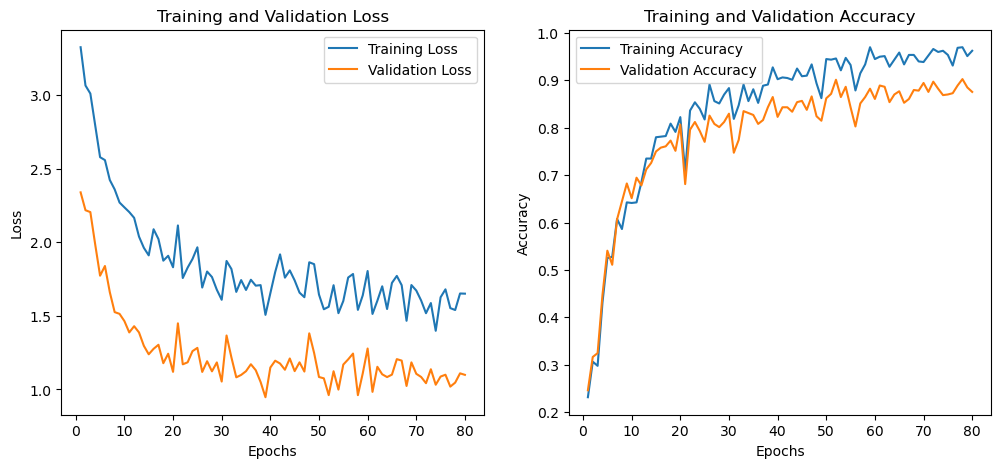

In [6]:
# Initialize lists to collect all values across files
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []

# Function to plot logs
def plot_logs(log_files, logs_dir):
    global all_train_losses, all_val_losses, all_train_accuracies, all_val_accuracies
    
    for log_file in log_files:
        log_path = os.path.join(logs_dir, log_file)
        with open(log_path) as f:
            log_data = json.load(f)
        # Access the correct keys and collect the data
        if 'train_losses' in log_data:
            all_train_losses.extend(log_data['train_losses'])
        if 'val_losses' in log_data:
            all_val_losses.extend(log_data['val_losses'])
        if 'train_accuracies' in log_data:
            all_train_accuracies.extend(log_data['train_accuracies'])
        if 'val_accuracies' in log_data:
            all_val_accuracies.extend(log_data['val_accuracies'])
            
    return all_train_losses, all_val_losses, all_train_accuracies, all_val_accuracies

# Collecting and plot all logs
all_train_losses, all_val_losses, all_train_accuracies, all_val_accuracies = plot_logs(log_files, logs_dir)

# Now, let's plot the collected data
if all_train_losses and all_val_losses and all_train_accuracies and all_val_accuracies:
    epochs = range(1, len(all_train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plotting Losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, all_train_losses, label='Training Loss')
    plt.plot(epochs, all_val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, all_train_accuracies, label='Training Accuracy')
    plt.plot(epochs, all_val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
else:
    print("Logs do not contain data for plotting.")


## 3. Model Performance Analysis

Next, we evaluate the model's performance by generating a classification report, confusion matrices, and a t-SNE plot of the extracted features.



Classification Report:
              precision    recall  f1-score   support

           1       0.93      1.00      0.96        74
           2       0.92      0.77      0.84        74
           3       0.82      0.82      0.82        74
           4       0.84      0.93      0.88        74
           5       0.90      0.88      0.89        74

    accuracy                           0.88       370
   macro avg       0.88      0.88      0.88       370
weighted avg       0.88      0.88      0.88       370



2024-08-21 20:40:47.114718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


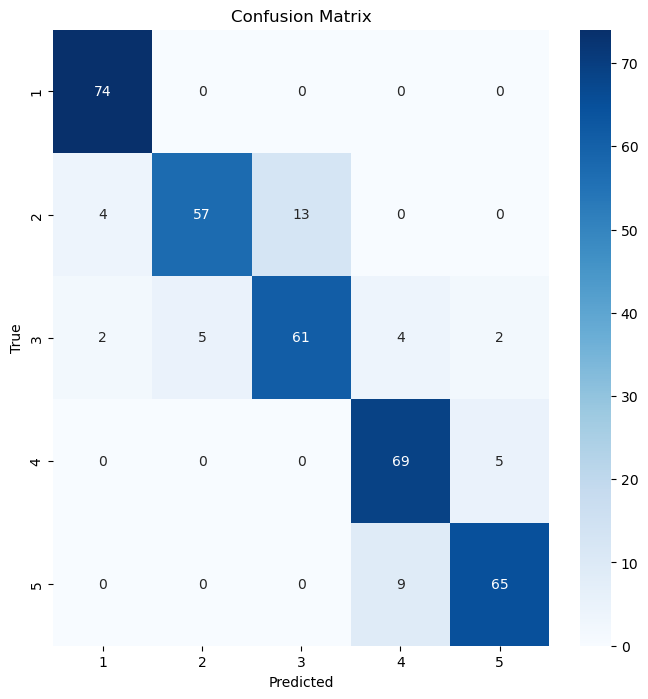

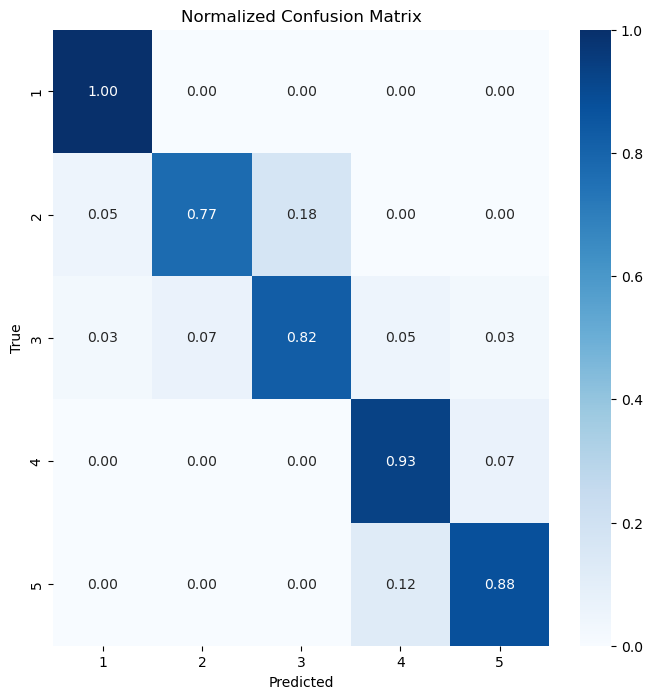


Sensitivity (per class): [1.         0.77027027 0.82432432 0.93243243 0.87837838]
Specificity (per class): [0.925      0.91935484 0.82432432 0.84146341 0.90277778]
AUC-ROC (macro average, one-vs-rest): 0.9256756756756757


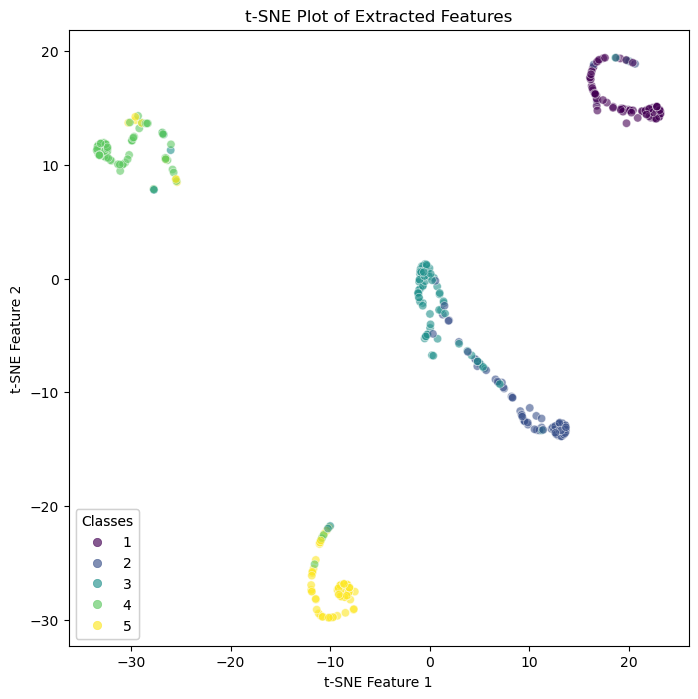

In [15]:
# Function to evaluate the model
def evaluate_model(model, source_val_dataset, class_names):
    y_true = []
    y_pred = []
    features = []

    for images, labels in source_val_dataset:
        output = model(images, training=False)
        logits = output if not isinstance(output, tuple) else output[0]

        y_true.extend(labels.numpy())
        y_pred.extend(tf.argmax(logits, axis=1).numpy())
        features.extend(logits.numpy())

    y_true = np.array(y_true) + 1
    y_pred = np.array(y_pred) + 1

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion matrix (unnormalized)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Confusion matrix (normalized)
    cm_normalized = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')
    plt.show()

    # Sensitivity and Specificity
    sensitivity = cm.diagonal() / cm.sum(axis=1)
    specificity = cm.diagonal() / cm.sum(axis=0)

    print("\nSensitivity (per class):", sensitivity)
    print("Specificity (per class):", specificity)

    # AUC-ROC
    y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)) + 1)
    y_pred_bin = label_binarize(y_pred, classes=np.arange(len(class_names)) + 1)

    auc_roc = roc_auc_score(y_true_bin, y_pred_bin, average="macro", multi_class="ovr")
    print(f"AUC-ROC (macro average, one-vs-rest): {auc_roc}")

    # t-SNE plot
    features = np.array(features)
    tsne = TSNE(n_components=2, random_state=40)
    features_2d = tsne.fit_transform(features)

    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=y_true, cmap='viridis', alpha=0.6, edgecolors='w', linewidth=0.5)
    legend11 = plt.legend(*scatter.legend_elements(), title="Classes")
    plt.gca().add_artist(legend11)
    plt.xlabel('t-SNE Feature 1')
    plt.ylabel('t-SNE Feature 2')
    plt.title('t-SNE Plot of Extracted Features')
    plt.show()

# Assuming source_test_dataset and class_names are already defined in previous cells
class_names = [str(i) for i in range(1, 6)]
evaluate_model(dann, source_test_dataset, class_names)


## 4. Model Robustness Check

Finally, we assess the model's robustness by introducing noise to the validation dataset and observing the changes in accuracy.


The model seems to be well-fitted.
Training Accuracy: 0.96, Validation Accuracy: 0.88
Training Loss: 1.65, Validation Loss: 1.10


2024-08-21 20:44:01.794518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-21 20:44:35.952315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-21 20:45:08.690713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Robustness Results:
Noise Level: 0.01: 0.8793
Noise Level: 0.05: 0.8721
Noise Level: 0.1: 0.8487


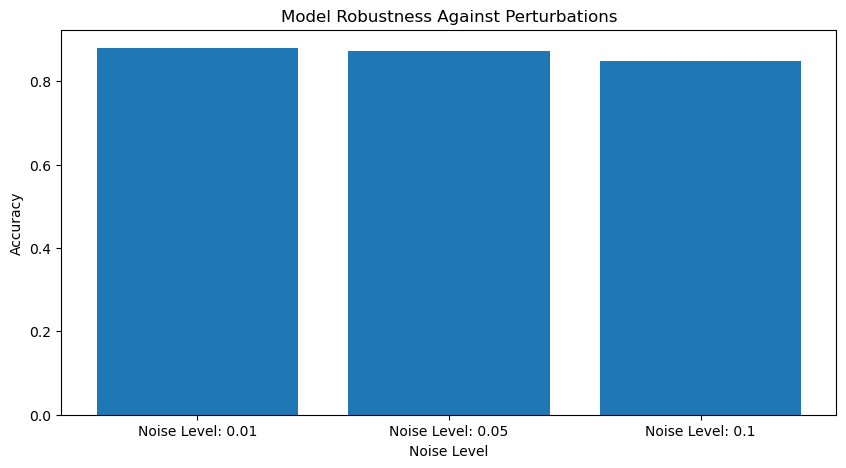

In [16]:
# Function to check for overfitting and underfitting
def check_overfitting_underfitting(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = len(train_losses)
    
    if epochs < 2:
        print("Not enough epochs to determine overfitting/underfitting.")
        return
    
    # Calculating the difference between training and validation loss/accuracy
    loss_diff = np.array(val_losses) - np.array(train_losses)
    acc_diff = np.array(train_accuracies) - np.array(val_accuracies)
    
    # Checking for overfitting: training accuracy much higher than validation accuracy
    if acc_diff[-1] > 0.1 and loss_diff[-1] > 0:
        print("Warning: The model may be overfitting.")
        print(f"Training Accuracy: {train_accuracies[-1]:.2f}, Validation Accuracy: {val_accuracies[-1]:.2f}")
        print(f"Training Loss: {train_losses[-1]:.2f}, Validation Loss: {val_losses[-1]:.2f}")
    
    # Checking for underfitting: both training and validation accuracy are low
    elif train_accuracies[-1] < 0.7 and val_accuracies[-1] < 0.7:
        print("Warning: The model may be underfitting.")
        print(f"Training Accuracy: {train_accuracies[-1]:.2f}, Validation Accuracy: {val_accuracies[-1]:.2f}")
    
    else:
        print("The model seems to be well-fitted.")
        print(f"Training Accuracy: {train_accuracies[-1]:.2f}, Validation Accuracy: {val_accuracies[-1]:.2f}")
        print(f"Training Loss: {train_losses[-1]:.2f}, Validation Loss: {val_losses[-1]:.2f}")

# Checking for overfitting and underfitting
check_overfitting_underfitting(all_train_losses, all_val_losses, all_train_accuracies, all_val_accuracies)

def check_model_robustness(model, dataset, noise_levels=[0.01, 0.05, 0.1], perturbation_type="gaussian"):
    robustness_results = {}
    
    for noise_level in noise_levels:
        perturbed_accuracies = []
        for images, labels in dataset:
            if perturbation_type == "gaussian":
                noise = np.random.normal(loc=0.0, scale=noise_level, size=images.shape)
            elif perturbation_type == "salt_pepper":
                noise = np.random.choice([0, 1], size=images.shape, p=[1 - noise_level, noise_level])
                noise = noise * np.random.choice([0, 1], size=images.shape)
            else:
                raise ValueError(f"Unknown perturbation type: {perturbation_type}")
            
            perturbed_images = images + noise
            perturbed_images = np.clip(perturbed_images, 0.0, 1.0)
            
            output = model(perturbed_images, training=False)
            logits = output if not isinstance(output, tuple) else output[0]
            preds = tf.argmax(logits, axis=1).numpy()
            accuracy = np.mean(preds == labels.numpy())
            perturbed_accuracies.append(accuracy)
        
        robustness_results[f"Noise Level: {noise_level}"] = np.mean(perturbed_accuracies)
    
    return robustness_results

# Checking robustness on perturbed data ("gaussian" or "salt_pepper") 
robustness_results = check_model_robustness(dann, source_test_dataset, perturbation_type="gaussian")

# Printting and visualize robustness results
print("\nRobustness Results:")
for noise_level, accuracy in robustness_results.items():
    print(f"{noise_level}: {accuracy:.4f}")

# Plotting the robustness results
plt.figure(figsize=(10, 5))
plt.bar(robustness_results.keys(), robustness_results.values())
plt.xlabel("Noise Level")
plt.ylabel("Accuracy")
plt.title("Model Robustness Against Perturbations")
plt.show()


# Embedding Extraction and Domain Adaptation Analysis

In this section, we extract embeddings from the source and target datasets using the DANN model. We then calculate the Proxy A-distance to measure domain adaptation effectiveness and visualize the results using t-SNE plots.

---

## 1. Extracting Embeddings from the Datasets

We use the trained DANN model to extract embeddings from both the source and target datasets. This step is crucial for understanding how well the model has adapted to the target domain.


In [17]:
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Function to extract embeddings, handling both labeled and unlabeled data
def get_embeddings(model, dataset, labeled=True):
    embeddings = []
    labels = []
    
    for data in dataset:
        if labeled:
            images, label_batch = data
            labels.append(label_batch.numpy())
        else:
            images = data
            
        images_rgb = ensure_rgb(images)
        images_resized = resize_images(images_rgb, 224, 224)
        features, _ = model(images_resized, alpha=0)
        embeddings.append(features.numpy())
    
    embeddings = np.concatenate(embeddings, axis=0)
    if labeled:
        labels = np.concatenate(labels, axis=0)
        return embeddings, labels
    else:
        return embeddings

# Getting embeddings for source and target datasets with DANN adaptation
adapted_source_embeddings, adapted_source_labels = get_embeddings(dann, source_test_dataset, labeled=True)
adapted_target_embeddings = get_embeddings(dann, target_val_dataset, labeled=False)


2024-08-21 20:45:40.070580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-21 20:46:00.373340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## 2. Computing Proxy A-distance

The Proxy A-distance is a measure of domain adaptation effectiveness. It is calculated by training a classifier to distinguish between the source and target embeddings. A smaller Proxy A-distance indicates better domain adaptation.


In [18]:
# Function to compute Proxy A-distance
def compute_proxy_a_distance(source_embeddings, target_embeddings):
    # Create labels for source (0) and target (1) embeddings
    X = np.concatenate((source_embeddings, target_embeddings), axis=0)
    y = np.concatenate((np.zeros(len(source_embeddings)), np.ones(len(target_embeddings))), axis=0)
    
    # Training a linear SVM classifier
    classifier = SVC(kernel='linear')
    classifier.fit(X, y)
    
    # Predicting labels and compute accuracy
    y_pred = classifier.predict(X)
    accuracy = accuracy_score(y, y_pred)
    
    # Computing Proxy A-distance
#    proxy_a_distance = 2 * (1 - accuracy)
    proxy_a_distance = 2 * (2 * accuracy - 1)

    return proxy_a_distance

# Calculating the Proxy A-distance
proxy_a_dist = compute_proxy_a_distance(adapted_source_embeddings, adapted_target_embeddings)
print(f"Proxy A-distance: {proxy_a_dist}")


Proxy A-distance: 0.7225806451612904


## 3. Visualizing t-SNE Embeddings with Domain Adaptation

Finally, we visualize the embeddings using t-SNE plots to observe how the source and target embeddings are distributed before and after adaptation.


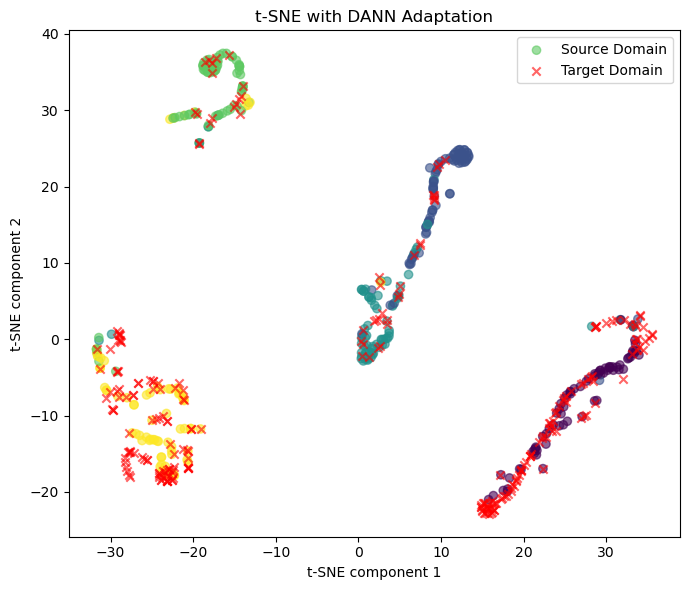

In [19]:
# Function to plot t-SNE for adapted embeddings
def plot_tsne_adapted(source_embeddings, source_labels, target_embeddings):
    tsne = TSNE(n_components=2)#, random_state=42)
    
    # Fitting and transform the adapted embeddings
    all_adapted_embeddings = np.concatenate([source_embeddings, target_embeddings], axis=0)
    tsne_adapted_embeddings = tsne.fit_transform(all_adapted_embeddings)
    tsne_adapted_source = tsne_adapted_embeddings[:len(source_embeddings)]
    tsne_adapted_target = tsne_adapted_embeddings[len(source_embeddings):]
    
    # Plotting the adapted t-SNE
    plt.figure(figsize=(7, 6))
    plt.scatter(tsne_adapted_source[:, 0], tsne_adapted_source[:, 1], c=source_labels, cmap='viridis', marker='o', alpha=0.6, label='Source Domain')
    plt.scatter(tsne_adapted_target[:, 0], tsne_adapted_target[:, 1], color='red', marker='x', alpha=0.6, label='Target Domain')
    plt.title('t-SNE with DANN Adaptation')
    plt.xlabel('t-SNE component 1')
    plt.ylabel('t-SNE component 2')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plotting the t-SNE with adaptation only
plot_tsne_adapted(adapted_source_embeddings, adapted_source_labels, adapted_target_embeddings)


In [20]:
# Function to extract embeddings before DANN adaptation
def get_pre_dann_embeddings(model, dataset, labeled=True):
    embeddings = []
    labels = []
    
    for data in dataset:
        if labeled:
            images, label_batch = data
            labels.append(label_batch.numpy())
        else:
            images = data
            
        images_rgb = ensure_rgb(images)
        images_resized = resize_images(images_rgb, 224, 224)
        features = model(images_resized)  # Direct feature extraction without DANN
        
        # Flatten the features
        features_flattened = features.numpy().reshape(features.shape[0], -1)
        
        embeddings.append(features_flattened)
    
    embeddings = np.concatenate(embeddings, axis=0)  # Combine all extracted embeddings
    if labeled:
        labels = np.concatenate(labels, axis=0)
        return embeddings, labels
    else:
        return embeddings

# Instantiate the base feature extractor model
base_model = build_feature_extractor(trainable=False)  # Setting trainable=False to keep the base model frozen
 
    
# Getting embeddings for unseen source and target datasets before DANN adaptation
source_embeddings, source_labels = get_pre_dann_embeddings(base_model, source_test_dataset, labeled=True)
target_embeddings = get_pre_dann_embeddings(base_model, target_val_dataset, labeled=False)


2024-08-21 20:46:33.855656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-21 20:54:53.326736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [21]:
# Calculating the Proxy A-distance before DANN adaptation
pre_dann_proxy_a_dist = compute_proxy_a_distance(source_embeddings, target_embeddings)
print(f"Proxy A-distance before DANN adaptation: {pre_dann_proxy_a_dist}")


Proxy A-distance before DANN adaptation: 2.0


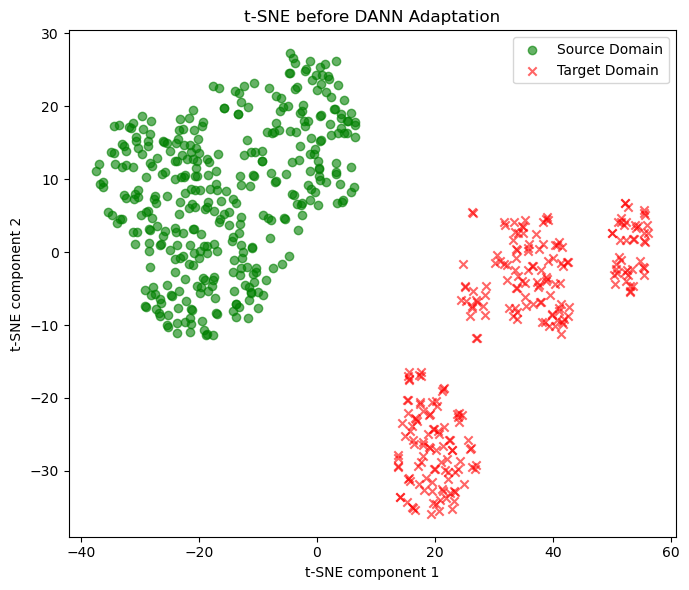

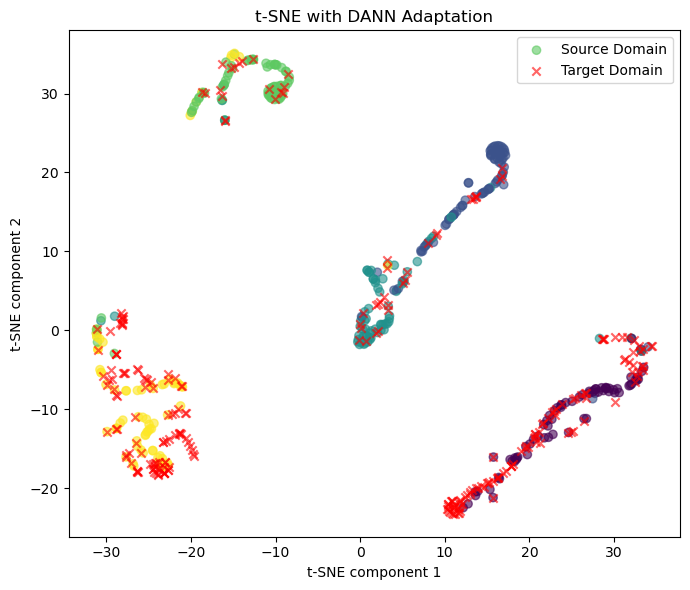

In [22]:

def plot_tsne_pre_dann(source_embeddings, target_embeddings):
    tsne = TSNE(n_components=2, random_state=42)
    
    # Fitting and transform the embeddings before adaptation
    all_embeddings = np.concatenate([source_embeddings, target_embeddings], axis=0)
    tsne_embeddings = tsne.fit_transform(all_embeddings)
    tsne_source = tsne_embeddings[:len(source_embeddings)]
    tsne_target = tsne_embeddings[len(source_embeddings):]
    
    # Plotting the t-SNE
    plt.figure(figsize=(7, 6))
    plt.scatter(tsne_source[:, 0], tsne_source[:, 1], color='green', marker='o', alpha=0.6, label='Source Domain')
    plt.scatter(tsne_target[:, 0], tsne_target[:, 1], color='red', marker='x', alpha=0.6, label='Target Domain')
    plt.title('t-SNE before DANN Adaptation')
    plt.xlabel('t-SNE component 1')
    plt.ylabel('t-SNE component 2')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plotting the t-SNE before DANN adaptation
plot_tsne_pre_dann(source_embeddings, target_embeddings)
# Plotting the t-SNE with adaptation only
plot_tsne_adapted(adapted_source_embeddings, adapted_source_labels, adapted_target_embeddings)


# 3D Vessel Visualization with Color-Coded Predictions

This section details the process of mapping the predicted plaque types from OCT cross-sectional images onto a 3D vessel model. The resulting visualizations provide a clear, color-coded representation of the vessel based on the model's predictions.

---

## 1. Setup and Model Loading

We begin by loading the pre-trained DANN model and preparing the necessary functions for image prediction and 3D model processing.


In [34]:
import os
from glob import glob
from PIL import Image, ImageOps
import pyvista as pv
import numpy as np
import tensorflow as tf
from matplotlib import cm, pyplot as plt
import gc

# Load and Compile the DANN Model
# Assuming 'dann' is already defined and loaded with the appropriate weights
dann_model = dann
dann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Function to predict plaque types from OCT images
def predict_plaque_type(image):
    # Ensure the image is in RGB format
    if image.mode != 'RGB':
        image = ImageOps.grayscale(image)
        image = ImageOps.colorize(image, black="black", white="white")
    
    # Resize image to match the model's input requirements
    image = image.resize((224, 224))  
    image_array = tf.keras.preprocessing.image.img_to_array(image)
    image_array = tf.expand_dims(image_array, axis=0)  # Add batch dimension
    image_array = image_array / 255.0  # Normalize pixel values

    # Predict the plaque type using the DANN model
    label_prediction, _ = dann_model.predict(image_array)
    predicted_class = tf.argmax(label_prediction, axis=-1)
    return predicted_class.numpy()[0]

# Function to extract Z-coordinates from the path data file
def read_path_data(path_file):
    z_coords = []
    with open(path_file, 'r') as file:
        for line in file:
            coords = line.strip().split()
            if len(coords) == 3:
                z_coords.append(float(coords[2]))  # Extract the Z-coordinate
    return np.array(z_coords)


## 2. Data Preparation

This step involves defining the datasets and corresponding file paths for the OCT images, STL files, and path data. The datasets represent different patients or cases that will be visualized.


In [36]:
# Define datasets and their corresponding image patterns and STL file paths
datasets = {
    'GA': {
        'pattern': 'K-Means_20_wetransfer_ga-oct_2024-02-28_1808_GA_OCT.dcm_*.png',
        'stl_file': '/Users/hatem/Library/CloudStorage/OneDrive-QueenMary,UniversityofLondon/3D Intractive Pullback-based Model/OCT_STL_conversion/GA/Stent -38 final.stl',
        'path_file': '/Users/hatem/Library/CloudStorage/OneDrive-QueenMary,UniversityofLondon/3D Intractive Pullback-based Model/OCT_STL_conversion/GA/Path 0.dat'
    },
    'HU': {
        'pattern': 'K-Means_20_wetransfer_ga-oct_2024-02-28_1808_Huczko_OCT.dcm_*.png',
        'stl_file': '/Users/hatem/Library/CloudStorage/OneDrive-QueenMary,UniversityofLondon/3D Intractive Pullback-based Model/OCT_STL_conversion/HU/Stent -138 final.stl',
        'path_file': '/Users/hatem/Library/CloudStorage/OneDrive-QueenMary,UniversityofLondon/3D Intractive Pullback-based Model/OCT_STL_conversion/HU/Path 0.dat'
    },
    'WH': {
        'pattern': 'K-Means_20_wetransfer_wh_2024-02-28_1810_WH.dcm_*.png', 
        'stl_file': '/Users/hatem/Library/CloudStorage/OneDrive-QueenMary,UniversityofLondon/3D Intractive Pullback-based Model/OCT_STL_conversion/WH/Stent -56 final.stl',
        'path_file': '/Users/hatem/Library/CloudStorage/OneDrive-QueenMary,UniversityofLondon/3D Intractive Pullback-based Model/OCT_STL_conversion/HU/Path 0.dat'
    },
    'ZP': {
        'pattern': 'K-Means_20_wetransfer_wh_2024-02-28_1810_ZP.dcm_*.png', 
        'stl_file': '/Users/hatem/Library/CloudStorage/OneDrive-QueenMary,UniversityofLondon/3D Intractive Pullback-based Model/OCT_STL_conversion/ZB/Stent 154 final.stl',
        'path_file': '/Users/hatem/Library/CloudStorage/OneDrive-QueenMary,UniversityofLondon/3D Intractive Pullback-based Model/OCT_STL_conversion/HU/Path 0.dat'
     },
    # Additional datasets can be added here...
}

## 3. Mapping Predictions onto 3D Vessel Models

For each dataset, the code loads the corresponding OCT images, predicts plaque types, and maps these predictions onto the 3D vessel models using the Z-coordinates from the path data.


In [37]:
# Main processing loop for each dataset
for dataset_name, data_info in datasets.items():
    image_pattern = data_info['pattern']
    stl_file_path = data_info['stl_file']
    path_file_path = data_info['path_file']

    # Load and sort the OCT image paths
    train_images_files = sorted(glob(os.path.join(target_train_data_dir, image_pattern)))
    val_images_files = sorted(glob(os.path.join(target_val_data_dir, image_pattern)))
    oct_images = train_images_files + val_images_files

    # Skip dataset if no images are found
    if len(oct_images) == 0:
        print(f"No OCT images found for dataset {dataset_name}. Skipping...")
        continue

    # Predict plaque types for all OCT images in the dataset
    plaque_predictions = [predict_plaque_type(Image.open(img)) for img in oct_images]

    # Load the STL file for the 3D vessel model
    stl_mesh = pv.read(stl_file_path)

    # Read Z-coordinates from the path data file
    z_coords = read_path_data(path_file_path)

    if len(stl_mesh.points) > 0 and len(z_coords) > 0:
        # Resample Z-coordinates if the number of Z-coordinates does not match the number of OCT images
        if len(z_coords) != len(oct_images):
            z_coords_resampled = np.interp(
                np.linspace(0, len(oct_images) - 1, len(oct_images)), 
                np.linspace(0, len(z_coords) - 1, len(z_coords)), z_coords)
        else:
            z_coords_resampled = z_coords

        # Map the predicted plaque types onto the 3D mesh based on Z-coordinate proximity
        image_indices = np.interp(stl_mesh.points[:, 2], z_coords_resampled, np.arange(len(oct_images)))
        stl_mesh.point_data['Image Index'] = image_indices
    else:
        print(f"Warning: STL mesh points or Z-coordinates are empty for dataset {dataset_name}.")
        continue

    # Ensure valid mapping of predictions
    if np.any(stl_mesh.point_data['Image Index'] < 0) or np.any(stl_mesh.point_data['Image Index'] >= len(oct_images)):
        print(f"Error in mapping Z-coordinates for dataset {dataset_name}.")
        continue

    # Define color mapping based on plaque predictions
    viridis = cm.get_cmap('viridis')
    class_colors = {
        0: viridis(2 / 11),
        1: viridis(3 / 11),
        2: viridis(5 / 11),
        3: viridis(7 / 11),
        4: viridis(10 / 11)
    }
    color_array = np.array([class_colors[plaque_predictions[int(idx) % len(plaque_predictions)]] 
                            for idx in stl_mesh.point_data['Image Index']])
    color_array = (color_array[:, :3] * 255).astype(np.uint8)
    stl_mesh.point_data['Classification'] = color_array


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━

/var/folders/ff/n4ql812x4xjgchyjrf3fy9880000gn/T/ipykernel_34650/4195591867.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━

## 4. Visualization and Output

In this final step, the mapped 3D vessel models are visualized and saved as images. These visualizations include color-coded representations of plaque types.


In [38]:
    # Scale the mesh for better visualization if needed
    max_bounds = np.max(stl_mesh.bounds)  
    scale_factor = 1.0 / max_bounds  
    stl_mesh.scale(scale_factor, inplace=True)

    # Set up the plotter for creating publication-quality figures
    plotter = pv.Plotter(off_screen=True)
    plotter.add_mesh(stl_mesh, scalars='Classification', rgb=True, show_scalar_bar=True)
    plotter.add_text(f"Dataset: {dataset_name}", position='upper_left', font_size=10)
    
    # Add a legend for the color-coded classes
    legend_entries = [
        ("Class 1", viridis(2 / 11)), 
        ("Class 2", viridis(3 / 11)), 
        ("Class 3", viridis(5 / 11)), 
        ("Class 4", viridis(7 / 11)),
        ("Class 5", viridis(10 / 11))
    ]
    plotter.add_legend(legend_entries, bcolor='w')

    # Enable axes for scale reference
    plotter.show_axes()

    # Save the generated plot as an image file
    output_path = f"{dataset_name}_OCT_3D_Plot.png"
    plotter.show(screenshot=output_path)

    # Clean up to free memory
    del stl_mesh
    del plotter
    gc.collect()


Widget(value='<iframe src="http://localhost:55544/index.html?ui=P_0x35cfa9a50_7&reconnect=auto" class="pyvista…

39293

# Combined Visualization of 3D Plots

This section combines the individual 3D visualizations of OCT-derived plaque predictions into a single figure arranged in a 2x2 grid. This allows for easy comparison across different datasets.


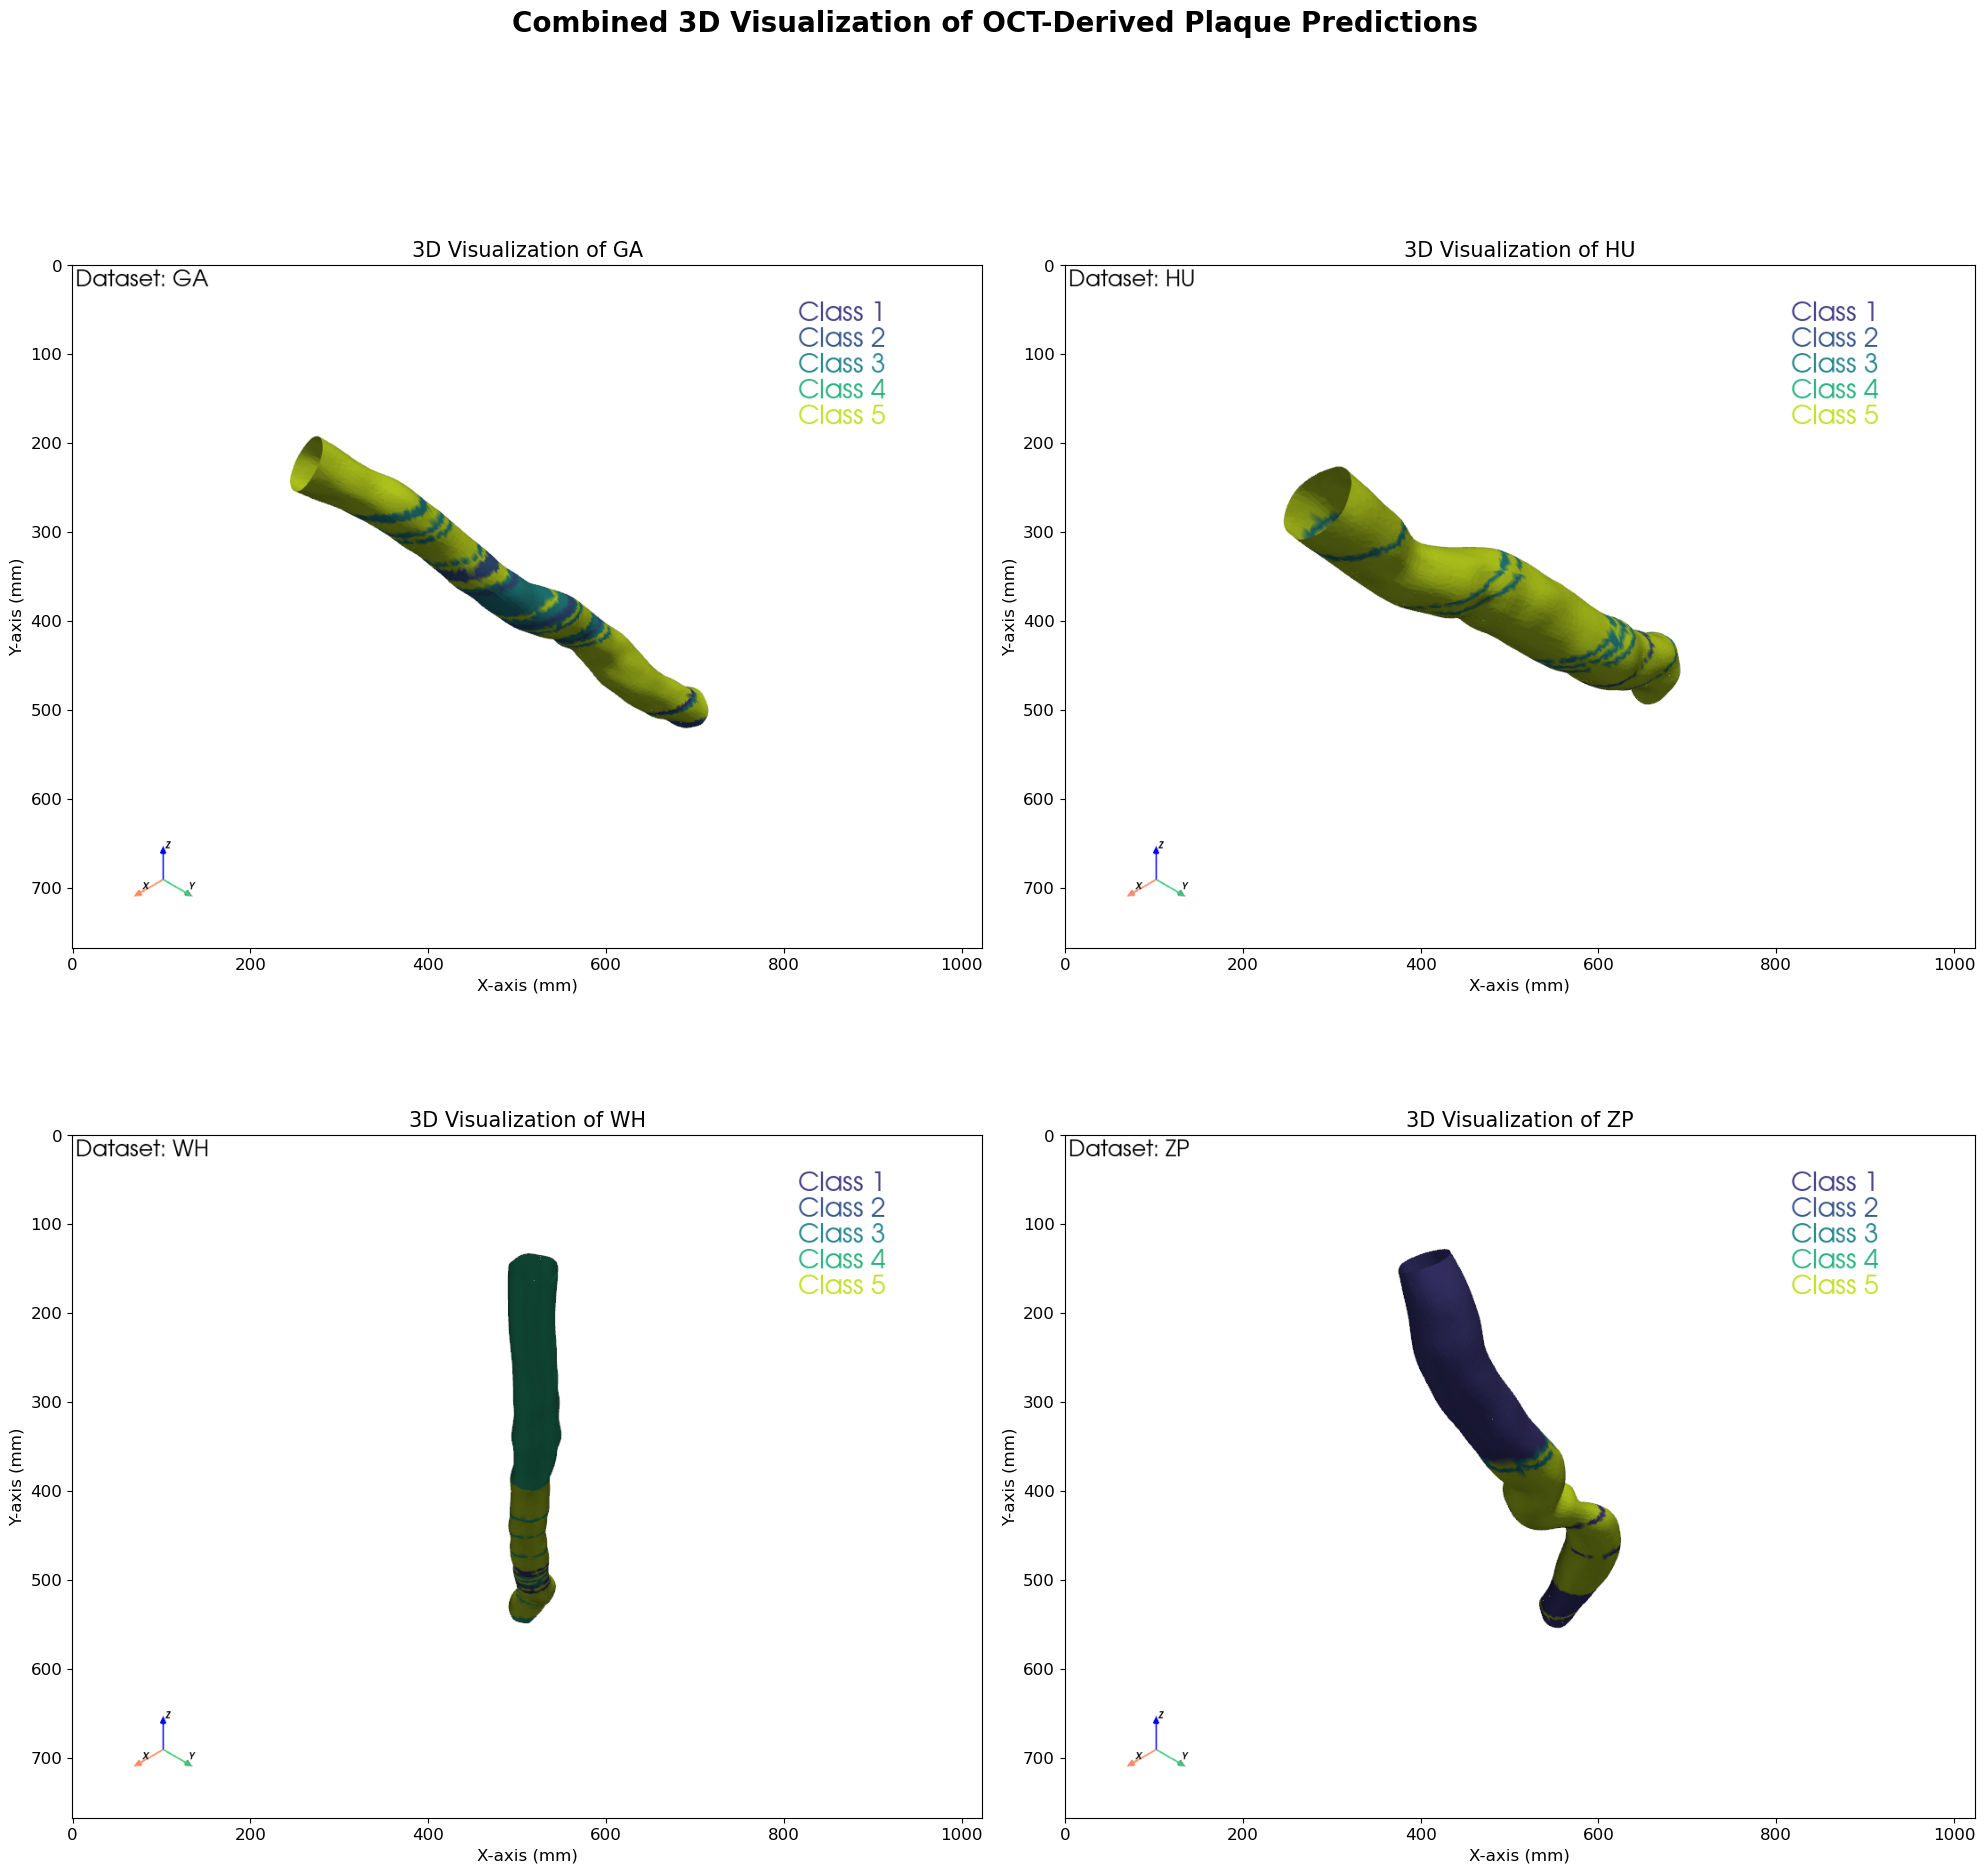

In [27]:
## 
import matplotlib.pyplot as plt
from PIL import Image
import os

# Define the directory containing the saved 3D plots
plot_directory = '/Users/hatem/MyDANN/DANN_Final '  # Replace with your directory path

# Define the dataset names corresponding to the saved plots
datasets = ['GA', 'HU', 'WH', 'ZP']  # We can add more dataset names if needed

# Load the images
images = [Image.open(os.path.join(plot_directory, f"{dataset}_OCT_3D_Plot.png")) for dataset in datasets]

# Create a figure for the combined plots in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(20, 20))  # Adjust figsize for larger images

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Add each image to a subplot with axes (toggle ruler)
for ax, img, dataset in zip(axes, images, datasets):
    ax.imshow(img)
    ax.set_title(f"3D Visualization of {dataset}", fontsize=15)  # Set title for each subplot
    ax.tick_params(axis='both', which='both', labelsize=12)  # Set tick label size for readability
    ax.set_xlabel('X-axis (mm)', fontsize=12)  # Set X-axis label
    ax.set_ylabel('Y-axis (mm)', fontsize=12)  # Set Y-axis label

# Set a main title for the figure
fig.suptitle("Combined 3D Visualization of OCT-Derived Plaque Predictions", fontsize=20, fontweight='bold')

# Adjust layout to ensure titles and images fit well
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title

# Save the combined figure
output_path = os.path.join(plot_directory, "Combined_OCT_3D_Plots_Large.png")
plt.savefig(output_path, dpi=300)
plt.show()


# Interactive 3D Visualization with Cross-Section Mapping

This section introduces an interactive 3D visualization tool that maps the predicted plaque types from OCT cross-sectional images onto a 3D vessel model. Users can interact with the 3D plot to view corresponding OCT cross-sections.

---

## 1. Setup and Model Loading

First, we set up the environment, suppress unnecessary TensorFlow logs, and load the pre-trained DANN model for predicting plaque types from OCT images.


In [45]:
import os
from glob import glob
from PIL import Image, ImageOps
import pyvista as pv
import numpy as np
import tensorflow as tf
from matplotlib import cm, pyplot as plt
import gc
from functools import partial

# Suppress TensorFlow logging except for errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Initialize the global variable for the current image
current_image = None

# Load and Compile the DANN Model
# Assuming 'dann' is already defined and loaded with the appropriate weights
dann_model = dann
dann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Function to predict plaque types from OCT images
def predict_plaque_type(image):
    # Ensure the image is in RGB format
    if image.mode != 'RGB':
        image = ImageOps.grayscale(image)
        image = ImageOps.colorize(image, black="black", white="white")
    
    # Resize image to match the model's input requirements
    image = image.resize((224, 224))  
    image_array = tf.keras.preprocessing.image.img_to_array(image)
    image_array = tf.expand_dims(image_array, axis=0)  # Add batch dimension
    image_array = image_array / 255.0  # Normalize pixel values

    # Predict the plaque type using the DANN model
    label_prediction, _ = dann_model.predict(image_array, verbose=0)  # Set verbose to 0 to suppress progress bar
    predicted_class = tf.argmax(label_prediction, axis=-1)
    return predicted_class.numpy()[0]


## 2. Data Preparation

Here, we define the datasets and corresponding file paths for the OCT images, STL files, and path data. The datasets represent different patients or cases that will be visualized.


In [49]:
# Define datasets and their corresponding image patterns and STL file paths
datasets = {
    'GA': {
        'pattern': 'K-Means_20_wetransfer_ga-oct_2024-02-28_1808_GA_OCT.dcm_*.png',
        'stl_file': '/Users/hatem/Library/CloudStorage/OneDrive-QueenMary,UniversityofLondon/3D Intractive Pullback-based Model/OCT_STL_conversion/GA/Stent -38 final.stl',
        'path_file': '/Users/hatem/Library/CloudStorage/OneDrive-QueenMary,UniversityofLondon/3D Intractive Pullback-based Model/OCT_STL_conversion/GA/Path 0.dat'
    },
    'HU': {
        'pattern': 'K-Means_20_wetransfer_ga-oct_2024-02-28_1808_Huczko_OCT.dcm_*.png',
        'stl_file': '/Users/hatem/Library/CloudStorage/OneDrive-QueenMary,UniversityofLondon/3D Intractive Pullback-based Model/OCT_STL_conversion/HU/Stent -138 final.stl',
        'path_file': '/Users/hatem/Library/CloudStorage/OneDrive-QueenMary,UniversityofLondon/3D Intractive Pullback-based Model/OCT_STL_conversion/HU/Path 0.dat'
    },
    'WH': {
        'pattern': 'K-Means_20_wetransfer_wh_2024-02-28_1810_WH.dcm_*.png', 
        'stl_file': '/Users/hatem/Library/CloudStorage/OneDrive-QueenMary,UniversityofLondon/3D Intractive Pullback-based Model/OCT_STL_conversion/WH/Stent -56 final.stl',
        'path_file': '/Users/hatem/Library/CloudStorage/OneDrive-QueenMary,UniversityofLondon/3D Intractive Pullback-based Model/OCT_STL_conversion/HU/Path 0.dat'
    },
    'ZP': {
        'pattern': 'K-Means_20_wetransfer_wh_2024-02-28_1810_ZP.dcm_*.png', 
        'stl_file': '/Users/hatem/Library/CloudStorage/OneDrive-QueenMary,UniversityofLondon/3D Intractive Pullback-based Model/OCT_STL_conversion/ZB/Stent 154 final.stl',
        'path_file': '/Users/hatem/Library/CloudStorage/OneDrive-QueenMary,UniversityofLondon/3D Intractive Pullback-based Model/OCT_STL_conversion/HU/Path 0.dat'
     },
    # Additional datasets can be added here...
}



## 3. Interactive Visualization and Cross-Section Mapping

In this step, we create an interactive 3D plot for each dataset. The 3D model is color-coded based on the predicted plaque types, and users can interact with the plot to view corresponding OCT cross-sections.


In [50]:
# Function to update the Matplotlib figure in a separate window
def update_cross_section(image_index, oct_images, plaque_predictions):
    plt.clf()  # Clear the figure
    current_image = Image.open(oct_images[image_index])

    # Create a new figure for the cross-section
    plt.imshow(np.array(current_image), cmap='gray')
    plt.title(f"OCT Cross-Section {image_index + 1} - Predicted Class: {plaque_predictions[image_index]+1}")
    plt.axis('off')
    plt.show()

# Function to display the 3D interactive plot and corresponding OCT cross-section
def display_3d_plot(dataset_name):
    data_info = datasets[dataset_name]

    image_pattern = data_info['pattern']
    stl_file_path = data_info['stl_file']
    path_file_path = data_info['path_file']

    # Load and sort the OCT image paths
    train_images_files = sorted(glob(os.path.join(target_train_data_dir, image_pattern)))
    val_images_files = sorted(glob(os.path.join(target_val_data_dir, image_pattern)))
    oct_images = train_images_files + val_images_files

    if len(oct_images) == 0:
        print(f"No OCT images found for dataset {dataset_name}.")
        return

    # Predict plaque types for all OCT images in the dataset
    plaque_predictions = [predict_plaque_type(Image.open(img)) for img in oct_images]

    # Load the STL file for the 3D vessel model
    stl_mesh = pv.read(stl_file_path)

    # Read Z-coordinates from the path data file
    z_coords = read_path_data(path_file_path)

    if len(stl_mesh.points) > 0 and len(z_coords) > 0:
        # Resample Z-coordinates if the number of Z-coordinates does not match the number of OCT images
        if len(z_coords) != len(oct_images):
            z_coords_resampled = np.interp(
                np.linspace(0, len(oct_images) - 1, len(oct_images)), 
                np.linspace(0, len(z_coords) - 1, len(z_coords)), z_coords)
        else:
            z_coords_resampled = z_coords

        # Map the predicted plaque types onto the 3D mesh based on Z-coordinate proximity
        image_indices = np.interp(stl_mesh.points[:, 2], z_coords_resampled, np.arange(len(oct_images)))
        stl_mesh.point_data['Image Index'] = image_indices

        # Define color mapping based on plaque predictions
        viridis = cm.get_cmap('viridis')
        class_colors = {
            0: viridis(2 / 11),
            1: viridis(3 / 11),
            2: viridis(5 / 11),
            3: viridis(7 / 11),
            4: viridis(10 / 11)
        }
        color_array = np.array([class_colors[plaque_predictions[int(idx) % len(plaque_predictions)]] 
                                for idx in stl_mesh.point_data['Image Index']])
        color_array = (color_array[:, :3] * 255).astype(np.uint8)
        stl_mesh.point_data['Classification'] = color_array

        # Scale the mesh for better visualization if needed
        max_bounds = np.max(stl_mesh.bounds)  
        scale_factor = 1.0 / max_bounds  
        stl_mesh.scale(scale_factor, inplace=True)

        # Set up the plotter for creating interactive 3D plots
        plotter = pv.Plotter(off_screen=False, window_size=(800, 800))  # Larger window to accommodate 3D model
        plotter.add_mesh(stl_mesh, scalars='Classification', rgb=True, show_scalar_bar=True)
        plotter.add_text(f"Dataset: {dataset_name}", position='upper_left', font_size=10)
        
        # Add a legend for the color-coded classes
        legend_entries = [
            ("Class 1", viridis(2 / 11)), 
            ("Class 2", viridis(3 / 11)), 
            ("Class 3", viridis(5 / 11)), 
            ("Class 4", viridis(7 / 11)),
            ("Class 5", viridis(10 / 11))
        ]
        plotter.add_legend(legend_entries, bcolor='w')

        # Callback for clicking on the vessel
        def point_picking_callback(point):
            z_coord = point[2]
            image_index = np.searchsorted(z_coords_resampled, z_coord)
            if image_index < len(oct_images):
                update_cross_section(image_index, oct_images, plaque_predictions)

        plotter.enable_point_picking(callback=point_picking_callback, show_message=True)

        # Slider for cross-section selection (positioned at the bottom center)
        plotter.add_slider_widget(lambda value: update_cross_section(int(round(value)) - 1, oct_images, plaque_predictions),
                                  [1, len(oct_images)], value=1, title="Cross-Section Slider",
                                  pointa=(0.3, 0.1), pointb=(0.7, 0.1), style='modern')

        # Show the interactive plot in a separate window
        plotter.show()

        # Clean up to free memory
        del stl_mesh
        del plotter
        gc.collect()


## 4. Running the Interactive Visualization

Finally, we select a dataset and run the interactive 3D visualization tool. This allows users to explore the 3D vessel model and view corresponding OCT cross-sections.


/var/folders/ff/n4ql812x4xjgchyjrf3fy9880000gn/T/ipykernel_34650/1919937283.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis')


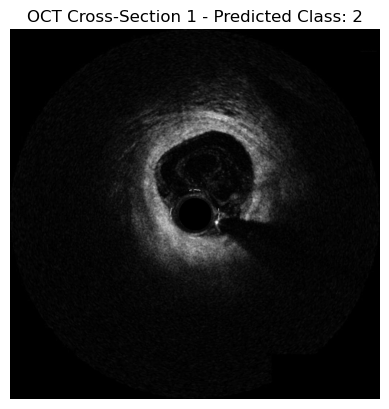

Widget(value='<iframe src="http://localhost:55544/index.html?ui=P_0x36b599010_8&reconnect=auto" class="pyvista…

In [51]:
# Select the dataset to visualize
selected_dataset = 'GA'  # Example selection
display_3d_plot(selected_dataset)


# Conclusion

The results show the effectiveness of the DANN model for domain adaptation. The model was trained and evaluated using source and target datasets. For more details, please refer to the code and additional resources on GitHub.
